## Initial Imports

In [110]:
import numpy as np
import ipdb
import matplotlib.pyplot as plt

from sklearn.datasets import load_digits
from sklearn.model_selection import GridSearchCV, LeaveOneOut
from sklearn.neighbors import KernelDensity

# Q2

## Part-1: Kernel Density Estimation

## Reading Data

In [111]:
digits = load_digits()
data = digits.data
labels = digits.target

In [112]:
mean_vec = data.mean(axis=0)

In [113]:
cov_mat = np.cov(data.T)

In [114]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

In [115]:
for ev in eig_vecs:
    np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))
print('Norm of all eigen vectors is 1')

Norm of all eigen vectors is 1


In [116]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

In [117]:
def reduced_data_get(X, num_features, eig_pairs):
    matrix_w = np.zeros(shape=(64,1))
    for i in range(num_features):
        matrix_w = np.hstack((matrix_w, eig_pairs[i][1].reshape(64,1)))

    # removing the first dummy column
    matrix_w = matrix_w[:, 1:]
    reduced_X = X @ matrix_w
    return reduced_X, matrix_w

### Choosing three reduced number of features (15, 25, 41)

In [118]:
r_data15, matrix_w15 = reduced_data_get(data, 15, eig_pairs)
r_data25, matrix_w25 = reduced_data_get(data, 25, eig_pairs)
r_data41, matrix_w41 = reduced_data_get(data, 41, eig_pairs)

In [119]:
bandwidths = 10 ** np.linspace(-1, 1, 20)

In [120]:
grid15 = GridSearchCV(KernelDensity(kernel='gaussian'),
                      {'bandwidth': bandwidths},
                      cv=5)
grid25 = GridSearchCV(KernelDensity(kernel='gaussian'),
                      {'bandwidth': bandwidths},
                      cv=5)
grid41 = GridSearchCV(KernelDensity(kernel='gaussian'),
                      {'bandwidth': bandwidths},
                      cv=5)

In [121]:
grid15.fit(r_data15)
grid25.fit(r_data25)
grid41.fit(r_data41)
print ("")

/home/bhavidhingra/Software/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/home/bhavidhingra/Software/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


/home/bhavidhingra/Software/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [136]:
kde15 = grid15.best_estimator_
kde25 = grid25.best_estimator_
kde41 = grid41.best_estimator_
print (grid15.best_params_, grid25.best_params_, grid41.best_params_)

{'bandwidth': 3.79269019073225} {'bandwidth': 2.9763514416313175} {'bandwidth': 2.3357214690901213}


In [137]:
new_data15 = kde15.sample(48, random_state=0)
new_data25 = kde25.sample(48, random_state=0)
new_data41 = kde41.sample(48, random_state=0)

In [138]:
new_data15.shape

(48, 15)

### Inverse Transform

In [139]:
new_data15 = (new_data15 @ matrix_w15.T)
new_data25 = (new_data25 @ matrix_w25.T)
new_data41 = (new_data41 @ matrix_w41.T)

In [140]:
new_data15.shape

(48, 64)

In [141]:
new_data15 = new_data15.reshape((4, 12, -1))
new_data25 = new_data25.reshape((4, 12, -1))
new_data41 = new_data41.reshape((4, 12, -1))

In [142]:
real_data = digits.data[:48].reshape((4, 12, -1))

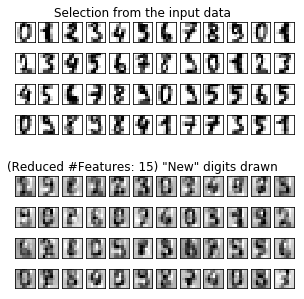

In [143]:
fig, ax = plt.subplots(9, 12, subplot_kw=dict(xticks=[], yticks=[]), figsize=(5,5))
for j in range(12):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im = ax[i + 5, j].imshow(new_data15[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        
ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('(Reduced #Features: 15) "New" digits drawn')

plt.show()

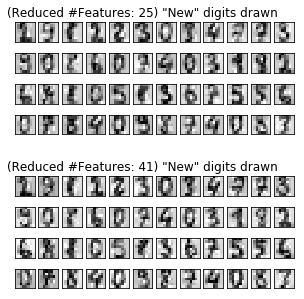

In [144]:
fig, ax = plt.subplots(9, 12, subplot_kw=dict(xticks=[], yticks=[]), figsize=(5,5))
for j in range(12):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(new_data25[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im = ax[i + 5, j].imshow(new_data41[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        
ax[0, 5].set_title('(Reduced #Features: 25) "New" digits drawn')
ax[5, 5].set_title('(Reduced #Features: 41) "New" digits drawn')

plt.show()

## Part-2: Gaussian Mixture Model based Density Estimation

### Initial Imports

In [145]:
from sklearn import mixture

### Utility Functions

In [146]:
n_components_range = range(1, 201, 10)

In [147]:
def plot_bic_scores(bic_list, cov_type, num_features):
    global n_components_range
    fig, ax = plt.subplots(figsize=(7,5))
    title = "Number of Features: "+ str(num_features) + ", Cov. type: " + cov_type
    ax.set_title(title)
    ax.set_xlabel("Number Of Components")
    ax.set_ylabel("BIC Scores")
    ax.plot(n_components_range, bic_list, label='BIC')

In [148]:
def best_bic_gmm_get(X):
    lowest_bic = np.infty
    bic = {}
    global n_components_range
    cov_types = ['spherical', 'tied', 'diag', 'full']
    for cov_type in cov_types:
        bic[cov_type] = []
        for n_components in n_components_range:
            # Fit a Gaussian mixture with EM
            gmm = mixture.GaussianMixture(n_components=n_components,
                                          covariance_type=cov_type)
            gmm.fit(X)
            bic[cov_type].append(gmm.bic(X))
            if bic[cov_type][-1] < lowest_bic:
                lowest_bic = bic[cov_type][-1]
                best_gmm = gmm
                best_cov_type = cov_type
                num_components = n_components

    return num_components, bic[best_cov_type], best_gmm, best_cov_type

In [149]:
n_components15, bic_list15, best_gmm15, best_cov_type15 = best_bic_gmm_get(r_data15)
n_components25, bic_list25, best_gmm25, best_cov_type25 = best_bic_gmm_get(r_data25)
n_components41, bic_list41, best_gmm41, best_cov_type41 = best_bic_gmm_get(r_data41)

In [150]:
print ("Best gmm for 15 features:\nnum_components: {}\ncovariance type: {}".format(n_components15, best_cov_type15))
print ("\n\nBest gmm for 25 features:\nnum_components: {}\ncovariance type: {}".format(n_components25, best_cov_type25))
print ("\n\nBest gmm for 41 features:\nnum_components: {}\ncovariance type: {}".format(n_components41, best_cov_type41))

Best gmm for 15 features:
num_components: 11
covariance type: full


Best gmm for 25 features:
num_components: 11
covariance type: full


Best gmm for 41 features:
num_components: 81
covariance type: full


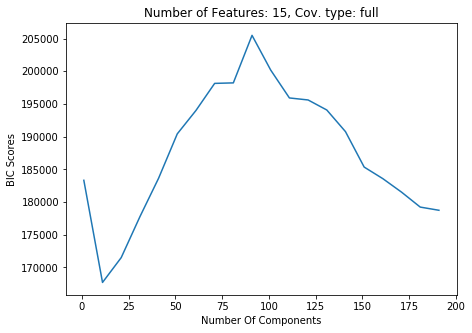

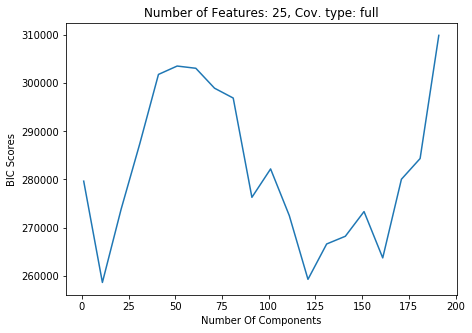

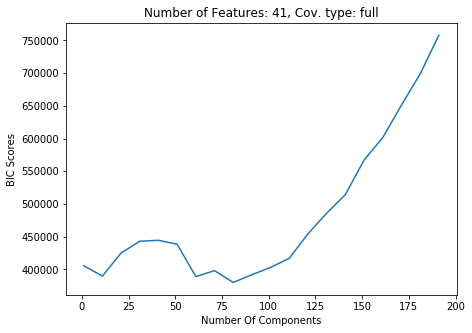

In [151]:
plot_bic_scores(bic_list15, best_cov_type15, 15)
plot_bic_scores(bic_list25, best_cov_type25, 25)
plot_bic_scores(bic_list41, best_cov_type41, 41)

In [152]:
new_gmm_data15 = best_gmm15.sample(48)[0]
new_gmm_data25 = best_gmm25.sample(48)[0]
new_gmm_data41 = best_gmm41.sample(48)[0]

In [153]:
new_gmm_data15 = (new_gmm_data15 @ matrix_w15.T)
new_gmm_data25 = (new_gmm_data25 @ matrix_w25.T)
new_gmm_data41 = (new_gmm_data41 @ matrix_w41.T)

In [154]:
new_gmm_data15 = new_gmm_data15.reshape((4, 12, -1))
new_gmm_data25 = new_gmm_data25.reshape((4, 12, -1))
new_gmm_data41 = new_gmm_data41.reshape((4, 12, -1))

In [155]:
new_gmm_data41.shape

(4, 12, 64)

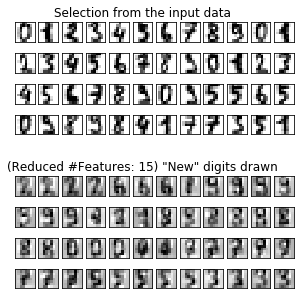

In [156]:
fig, ax = plt.subplots(9, 12, subplot_kw=dict(xticks=[], yticks=[]), figsize=(5,5))
for j in range(12):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(real_data[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im = ax[i + 5, j].imshow(new_gmm_data15[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')

ax[0, 5].set_title('Selection from the input data')
ax[5, 5].set_title('(Reduced #Features: 15) "New" digits drawn')

plt.show()

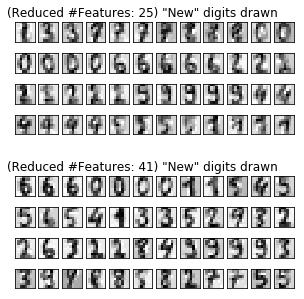

In [157]:
fig, ax = plt.subplots(9, 12, subplot_kw=dict(xticks=[], yticks=[]), figsize=(5,5))
for j in range(12):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(new_gmm_data25[i, j].reshape((8, 8)),
                             cmap=plt.cm.binary, interpolation='nearest')
        im = ax[i + 5, j].imshow(new_gmm_data41[i, j].reshape((8, 8)),
                                 cmap=plt.cm.binary, interpolation='nearest')
        
ax[0, 5].set_title('(Reduced #Features: 25) "New" digits drawn')
ax[5, 5].set_title('(Reduced #Features: 41) "New" digits drawn')

plt.show()